# demo of graph optimisation to segment structures

In [1]:
from grace.base import GraphAttrs
from grace.simulator.simulate_graph import random_graph
from grace.models.datasets import dataset_from_subgraphs
from grace.models.optimise import optimise_graph

import matplotlib.pyplot as plt
import numpy as np
from scipy.special import softmax

import networkx as nx

# import torch

In [2]:
G = random_graph(n_motifs=3, density=0.01, motif="line")

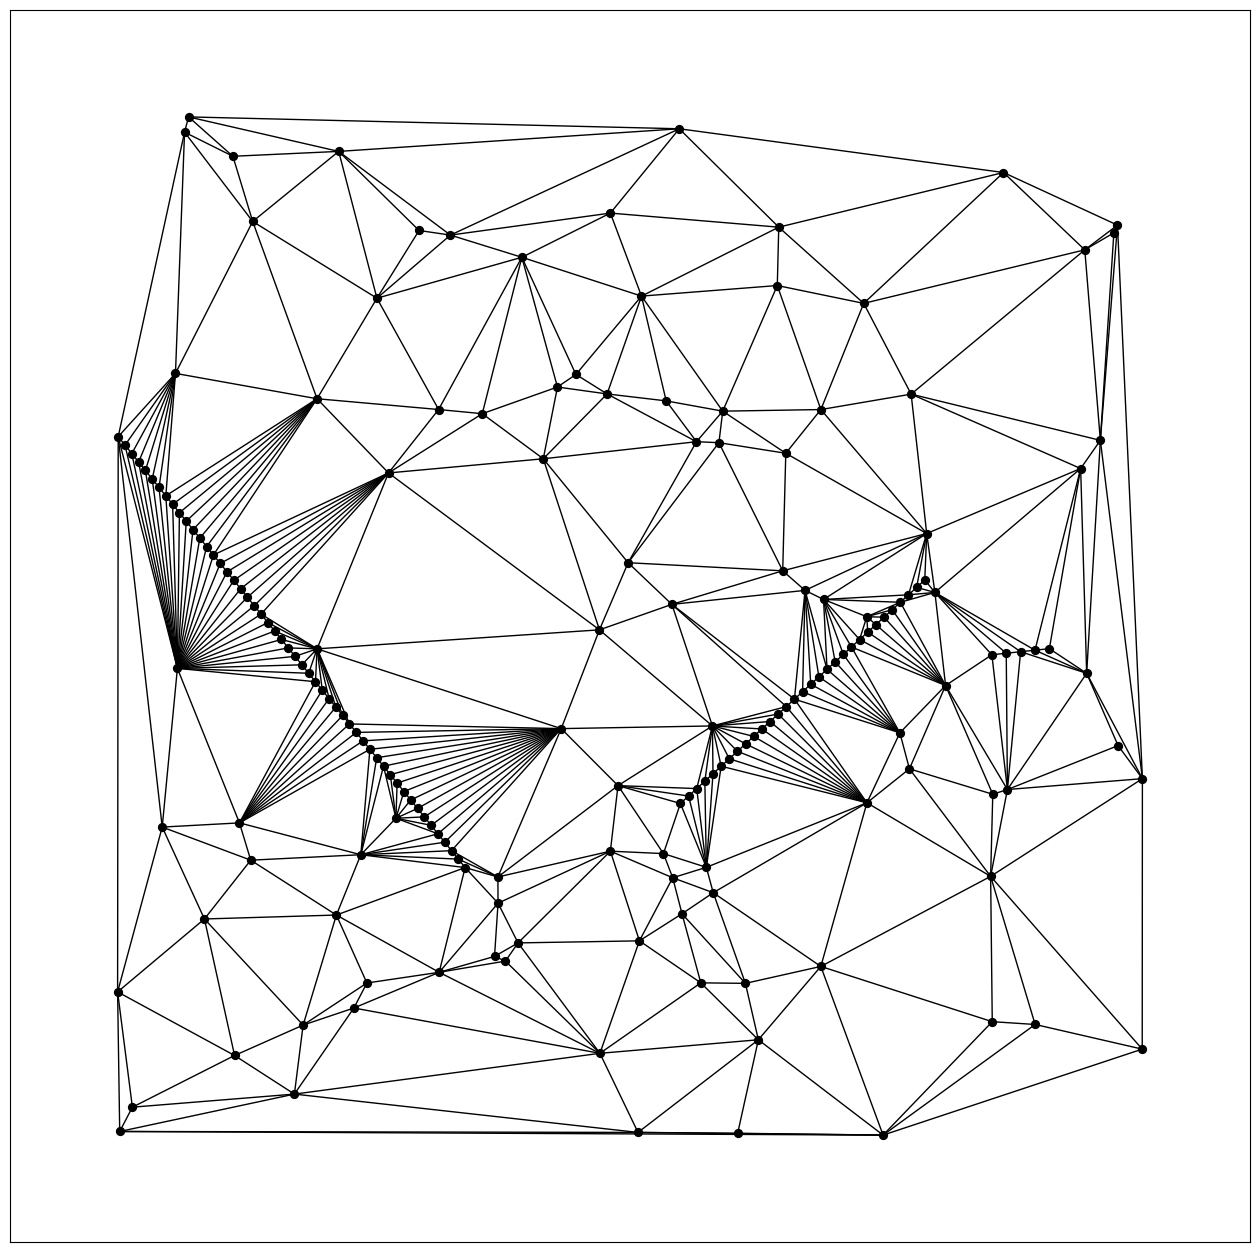

In [3]:
pos = {idx: (node[GraphAttrs.NODE_X], node[GraphAttrs.NODE_Y]) for idx, node in G.nodes(data=True)}
fig, ax = plt.subplots(figsize=(16, 16))

# draw all nodes/vertices in the graph, including those not determined to be 
# part of the objects
nx.draw_networkx(G, ax=ax, pos=pos, with_labels=False, node_color="k", node_size=32)

In [4]:
# model = torch.load("./gcn.pt")

In [5]:
def get_node_predictions(G, model):
    model.eval()

    predictions = []
    dataset = dataset_from_subgraphs(G, n_hop=1, in_train_mode=False)

    for data in dataset:  # Iterate in batches over the training/test dataset.
        out = model(data.x, data.edge_index)
        pred = out.argmax(dim=1)
        probs = softmax(out.detach().numpy())

        predictions.append((int(pred.numpy()), probs))

    # this is the prediction that the node is in the object
    for (_, node), pred in zip(G.nodes.data(), predictions):
        # for a FP, we want this to be the prob that it's *NOT* in the object
        # print(pred)
        node[GraphAttrs.NODE_PREDICTION] = np.clip(float(pred[1][0, 0]), 0, 1)

    return G

In [6]:
def get_edge_predictions(G, model):
    # TODO
    pass

In [7]:
# NOTE(arl): this is *super* hacky - just to see if the optimisation works

def update_graph_dummy(G):

    # G = get_predictions(G, model)

    nodes = list(G.nodes.data())

    for _, node in nodes:
        pd = np.random.random()*0.5
        if node["label"] > 0:
            node[GraphAttrs.NODE_PREDICTION] = pd
        else:
            node[GraphAttrs.NODE_PREDICTION] = 1-pd

    
    for edge in G.edges.data():
        pd = np.random.random()*0.1
        _, e_i = nodes[edge[0]]
        _, e_j = nodes[edge[1]]
        
        if e_i["object_idx"] == e_j["object_idx"] and e_i["label"] > 0:
            edge[2][GraphAttrs.EDGE_PREDICTION] = 1 - pd
        else:
            edge[2][GraphAttrs.EDGE_PREDICTION] = pd 


In [8]:
update_graph_dummy(G)

In [9]:
x = optimise_graph(G)

225
1108
0 Hypothesis(i=0, j=None, rho=0.8856804787340077) 0.8856804787340077 <class 'float'>
1 Hypothesis(i=None, j=0, rho=0.8856804787340077) 0.8856804787340077 <class 'float'>
2 Hypothesis(i=1, j=None, rho=0.5768640165522408) 0.5768640165522408 <class 'float'>
3 Hypothesis(i=None, j=1, rho=0.5768640165522408) 0.5768640165522408 <class 'float'>
4 Hypothesis(i=2, j=None, rho=0.717771903192984) 0.717771903192984 <class 'float'>
5 Hypothesis(i=None, j=2, rho=0.717771903192984) 0.717771903192984 <class 'float'>
6 Hypothesis(i=3, j=None, rho=0.6788318273688321) 0.6788318273688321 <class 'float'>
7 Hypothesis(i=None, j=3, rho=0.6788318273688321) 0.6788318273688321 <class 'float'>
8 Hypothesis(i=4, j=None, rho=0.8590467775866149) 0.8590467775866149 <class 'float'>
9 Hypothesis(i=None, j=4, rho=0.8590467775866149) 0.8590467775866149 <class 'float'>
10 Hypothesis(i=5, j=None, rho=0.943182102480158) 0.943182102480158 <class 'float'>
11 Hypothesis(i=None, j=5, rho=0.943182102480158) 0.943182102

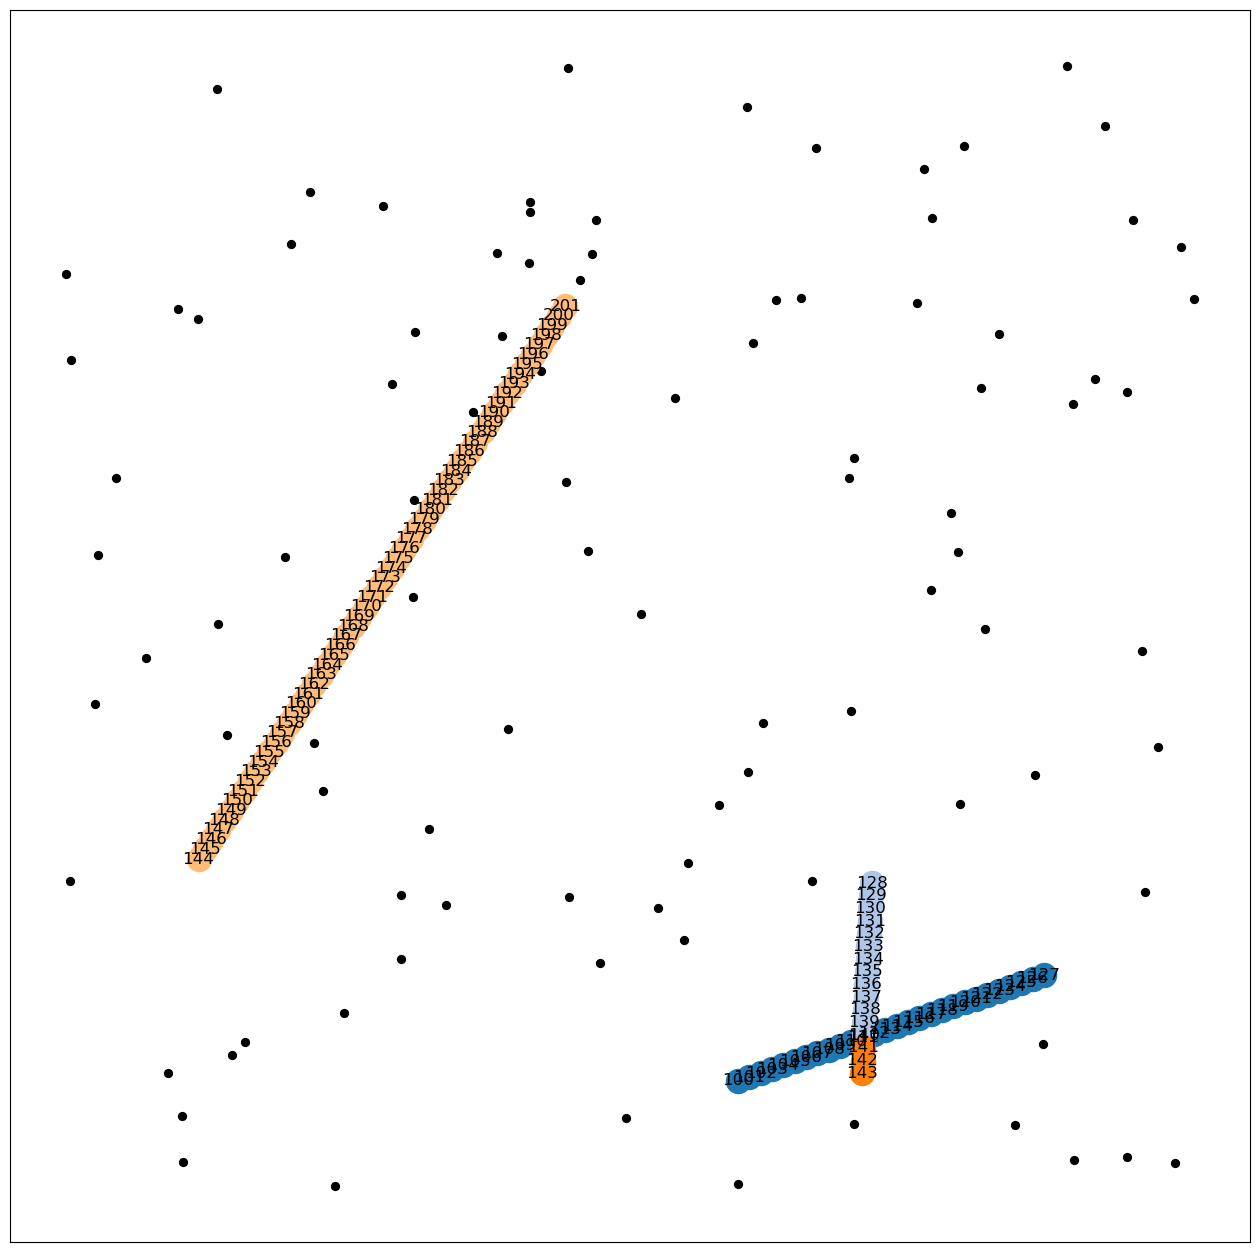

In [22]:


# plt.ion()

pos = {idx: (node[GraphAttrs.NODE_X], node[GraphAttrs.NODE_Y]) for idx, node in x.nodes(data=True)}
fig, ax = plt.subplots(figsize=(16, 16))

# draw all nodes/vertices in the graph, including those not determined to be 
# part of the objects
nx.draw_networkx(x, ax=ax, pos=pos, with_labels=False, node_color="k", node_size=32)

# get each connected subgraph and draw it with a different colour
cc = nx.connected_components(x)
for index, sg in enumerate(cc):
    if len(sg) <= 1:
        continue

    c_idx = np.array(plt.cm.tab20((index % 20) / 20)).reshape(1, -1)
    sg = x.subgraph(sg).copy()
    nx.draw_networkx(sg, pos=pos, edge_color=c_idx, node_color=c_idx)
plt.show()